In [77]:
# Import packages
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import function_library_assignment_2 as fnc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

%load_ext autoreload
%autoreload 2

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] =True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['axes.axisbelow'] = True

pd.set_option('display.precision', 5)
pd.options.display.float_format = '{:.5f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Load data using function from function_library_assignment_2.py
wind_hour = 31
n_bus = 24
gen_data = fnc.read_data('gen_data')
system_demand = fnc.read_data('system_demand')['System Demand']
load_distribution = fnc.read_data('load_distribution')
gen_data = fnc.read_data('gen_data')[['Unit #', 'Node', 'P max MW', 'R+ MW','R- MW']] #"The commitment and ramping constraints and costs of all generators can be neglected."
gen_costs = fnc.read_data('gen_costs')
wind_data = fnc.read_data('wind_data', wind_hour=wind_hour, wind_scenarios=np.arange(100)) #The ED is only for a single hour - in this case, we choose hour 31 and all wind scenarios

gen_costs

,Unit #,C ($/MWh),Cu ($/MWh),Cd ($/MWh),C+($/MWh),C-($/MWh)
0,1,13.32,15.00,14.00,15.00,11.00
1,2,13.32,15.00,14.00,15.00,11.00
2,3,20.70,10.00,9.00,24.00,16.00
3,4,20.93,8.00,7.00,25.00,17.00
4,5,26.11,7.00,5.00,28.00,23.00
5,6,10.52,16.00,14.00,16.00,7.00
6,7,10.52,16.00,14.00,16.00,7.00
7,8,6.02,0.00,0.00,0.00,0.00
8,9,5.47,0.00,0.00,0.00,0.00
9,10,0.00,0.00,0.00,0.00,0.00


Assumption: Based on the exercises, we set the day-ahead cost of the wind farm to be 5% of the average cost of the gens and the regulation cost to be 10% of the average regulation cost of the gens

In [79]:
# Define wind farm costs
wf_costs = gen_costs.iloc[0:6].copy()
wf_costs['C ($/MWh)'] = 0.05 * gen_costs['C ($/MWh)'].mean()
wf_costs['C+($/MWh)'] = 0.1 * gen_costs['C+($/MWh)'].mean()
wf_costs['C-($/MWh)'] = 0.1 * gen_costs['C-($/MWh)'].mean()
wf_costs['Cu ($/MWh)'] = 0.1 * gen_costs['Cu ($/MWh)'].mean()
wf_costs['Cd ($/MWh)'] = 0.1 * gen_costs['Cd ($/MWh)'].mean()
wf_costs

,Unit #,C ($/MWh),Cu ($/MWh),Cd ($/MWh),C+($/MWh),C-($/MWh)
0,1,0.62,1.00,0.89,1.41,0.90
1,2,0.62,1.00,0.89,1.41,0.90
2,3,0.62,1.00,0.89,1.41,0.90
3,4,0.62,1.00,0.89,1.41,0.90
4,5,0.62,1.00,0.89,1.41,0.90
5,6,0.62,1.00,0.89,1.41,0.90


In [80]:
# Define parameters
t = 0 #hour
demand = system_demand[t]

NUM_GEN = len(gen_data.index)
NUM_WF = len(wind_data.index)
P_MAX_WF = 300

### Setup normal distribution

We normalize the wind power data

In [82]:
# Normalize wind data
wind_data = wind_data / P_MAX_WF

In [83]:
# Define covariance matrix
cov = wind_data[wind_data.columns[:-1]].T.cov().values
wind_data[wind_data.columns[:-1]].T.cov()

Wind Farm,1,2,3,4,5,6
Wind Farm,,,,,,
1,0.01114,0.00760,0.00724,0.00485,0.00019,0.00162
2,0.00760,0.01642,0.00776,0.00657,0.00204,0.00253
3,0.00724,0.00776,0.01842,0.01050,0.00036,0.00167
4,0.00485,0.00657,0.01050,0.01491,0.00163,0.00235
5,0.00019,0.00204,0.00036,0.00163,0.00567,0.00020
6,0.00162,0.00253,0.00167,0.00235,0.00020,0.01392


In [84]:
# Define mean vector
mu = wind_data[wind_data.columns[:-1]].T.mean().values
mu

array([0.29278438, 0.28316482, 0.31727709, 0.31392262, 0.17980337,
       0.18237634])

Set reliability parameter

In [110]:
# Define epsilon
epsilon = 0.1

The inverse CDF of a STANDARD normal distribution

In [111]:
from scipy.stats import norm
norm.ppf(1 - epsilon)

0.6744897501960817

# Setup model

In [112]:
# Define ranges and hyperparameters  
CONTROLLABLE_GENERATORS = [i for i in range(12)] #range of controllable generators
WIND_GENERATORS = [i for i in range(12, 18)] #range of wind generators
GENERATORS = [i for i in range(18)] #range of all generators
LOAD = system_demand[t] #system load

# Set values of input parameters
dispatch_cost = {} # Generation costs in DKK/MWh
reserve_cost_up = {} # costs for upward reserve in DKK/MW
reserve_cost_down = {} # costs for downward reserve in DKK/MW
adjustment_cost_up = {} # costs for upward adjustments in real time in DKK/MWh
adjustment_cost_down = {} # costs for downward adjustments in real time in DKK/MWh
generation_capacity = {} # Generators capacity (Q^G_i) in MW
adjustment_capacity_up = {} # upward adjustment capacity (Q^up_i) in MW
adjustment_capacity_down = {} # downward adjustment capacity (Q^dw_i) in MW
wind_availability_scenario = {} # scenarios of available wind production -
wind_availability_expected = {}
wind_availability_standard_deviation = {}
wind_availability_min ={} # min available wind production (normalized)
wind_availability_max = {} # max available wind production (normalized)

for g in GENERATORS:
    if g < 12:
        dispatch_cost[g] = gen_costs['C ($/MWh)'][g]
        reserve_cost_up[g] = gen_costs['Cu ($/MWh)'][g]
        reserve_cost_down[g] = gen_costs['Cd ($/MWh)'][g]
        adjustment_cost_up[g] = gen_costs['C+($/MWh)'][g]
        adjustment_cost_down[g] = gen_costs['C-($/MWh)'][g]
        generation_capacity[g] = gen_data['P max MW'][g]
        adjustment_capacity_up[g] = gen_data['R+ MW'][g]
        adjustment_capacity_down[g] = gen_data['R- MW'][g]

    else:
        dispatch_cost[g] = wf_costs['C ($/MWh)'][g - 12] # Generation costs in DKK/MWh
        reserve_cost_up[g] = wf_costs['Cu ($/MWh)'][g - 12]
        reserve_cost_down[g] = wf_costs['Cd ($/MWh)'][g - 12]
        adjustment_cost_up[g] = wf_costs['C+($/MWh)'][g - 12]
        adjustment_cost_down[g] = wf_costs['C-($/MWh)'][g - 12]
        generation_capacity[g] = P_MAX_WF
        adjustment_capacity_up[g] = P_MAX_WF
        adjustment_capacity_down[g] = P_MAX_WF

wind_availability_expected = wind_data['Expected'].values

wind_availability_standard_deviation = np.diag(cov)

# Code largely based on solution from exercise 12:

In [113]:
def _solve_reserve_dimensioning_model_():
    
    # Create a Gurobi model for the optimization problem
    DA_model = gb.Model(name='Day-ahead economic dispatch and reserve dimensioning problem')
        
        
    # Set time limit
    DA_model.Params.TimeLimit = 500
    
    # Add variables to the Gurobi model
    # first-stage variables

    generator_dispatch = {} # electricity production of generators      
    generator_reserve_up = {} # upward reserves of generators        
    generator_reserve_down = {} # downward reserves of generators      
    
    for g in CONTROLLABLE_GENERATORS:
        generator_dispatch[g] = DA_model.addVar(lb=0,ub=generation_capacity[g],name='Dispatch of generator {0}'.format(g))
        generator_reserve_up[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[g],name='Upward reserve of generator {0}'.format(g))
        generator_reserve_down[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[g],name='Downward reserve of generator {0}'.format(g))

    for w in WIND_GENERATORS:
        generator_dispatch[w] = DA_model.addVar(lb=0,ub=generation_capacity[w],name='Dispatch of wind farm {0}'.format(w - 12))
        generator_reserve_up[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[w],name='Upward reserve of wind farm {0}'.format(w - 12))
        generator_reserve_down[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[w],name='Downward reserve of wind farm {0}'.format(w - 12))

    # linear decision rules for second-stage variables
    generator_adjustment_up_intersect = {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name='upward adjustment LDR parameter of generator {0} '.format(g)) for g in GENERATORS} # electricity production adjustment of generators in real time (\Delta x^G_i)
    generator_adjustment_down_intersect = {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name='downward adjustment LDR parameter of generator {0} '.format(g)) for g in GENERATORS} # electricity production adjustment of generators in real time (\Delta x^G_i)
    generator_adjustment_up = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('upward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS} for w in range(NUM_WF)]
    generator_adjustment_down = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('downward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS} for w in range(NUM_WF)] 

    #auxiliary variables for SOC constraints (non-negative), RHS of chance constraints
    y = [{g:DA_model.addVar(lb=0) for g in GENERATORS} for n in range(6)] #RHS auxiliary variables - we have 6 chance constraints

    #Constructing the LHS vectors associated with each chance constraint
    x_1 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_2 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_3 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_4 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_5 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_6 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in CONTROLLABLE_GENERATORS} for w in range(NUM_WF)]
    x_7 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in WIND_GENERATORS} for w in range(NUM_WF)]
     
    
    # update gurobi model
    DA_model.update()
    
    # Set objective function and optimization direction of the Gurobi model
    total_cost = gb.quicksum(dispatch_cost[g] * generator_dispatch[g] + reserve_cost_up[g] * generator_reserve_up[g] + reserve_cost_down[g] * generator_reserve_down[g] 
                             + adjustment_cost_up[g] * generator_adjustment_up_intersect[g] - adjustment_cost_down[g] * generator_adjustment_down_intersect[g] 
                             + gb.quicksum(wind_availability_expected[w] * (adjustment_cost_up[g] * generator_adjustment_up[w][g] 
                                                                            - adjustment_cost_down[g] * generator_adjustment_down[w][g]) for w in range(NUM_WF))
                             for g in GENERATORS) # expected electricity production cost
    
    DA_model.setObjective(total_cost, gb.GRB.MINIMIZE) #minimize cost

    # Add constraints to the Gurobi model
    # DA balance equation (Eq. 34 in report)
    DA_balance_constraint = DA_model.addConstr(gb.quicksum(generator_dispatch[g] for g in GENERATORS) == LOAD, name='Day-ahead balance equation')
 

    # DA_dispatch_min_constraint (Eq. 40 and 41 in report)
    DA_dispatch_min_constraint = {g:DA_model.addLConstr(generator_dispatch[g] - generator_reserve_down[g], 
                                                       gb.GRB.GREATER_EQUAL,
                                                       0,name='day-ahead dispatch and reserved capacity lower bound') for g in GENERATORS}
    
    # DA_dispatch_max_constraint for synchronous generators (Eq. 39 in report)
    DA_dispatch_max_constraint = {}
    for g in CONTROLLABLE_GENERATORS:
        DA_dispatch_max_constraint[g] = DA_model.addLConstr(generator_dispatch[g] + generator_reserve_up[g], 
                                                           gb.GRB.LESS_EQUAL,
                                                           generation_capacity[g], name='day-ahead dispatch and reserved capacity upper bound')
    
    # reformulation of chance-constrained DA_dispatch_max_constraint for wind generators (Eq. 42 in report)
 
    k = 0
    for g in WIND_GENERATORS:
        DA_dispatch_max_constraint[g] = DA_model.addLConstr(generator_dispatch[g] + generator_reserve_up[g] 
                                                           + norm.ppf(1-epsilon) * wind_availability_standard_deviation[k] * generation_capacity[g], 
                                                           gb.GRB.LESS_EQUAL,
                                                           wind_availability_expected[k] * generation_capacity[g], name='day-ahead dispatch and reserved capacity upper bound')
        k+=1

    #reformulation of robust RT_balance_constriant (Eq. 43 in report)      
    # RT_balance_constraint_intersect = DA_model.addLConstr(
    #         gb.quicksum(generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g] for g in GENERATORS),
    #         gb.GRB.EQUAL,
    #         0,name='real-time balance equation (intercept of LDR)')

    # RT_balance_constraint = []

    # for w in range(NUM_WF):
    #     RT_balance_constraint.append(
    #         DA_model.addLConstr(gb.quicksum(generator_adjustment_up[w][g] - generator_adjustment_down[w][g] for g in GENERATORS),
    #         gb.GRB.EQUAL,
    #         0,name='real-time balance equation (slope of LDR associated with wind power of WF%d)' % w)
    #     )

    #RT_balance_constriant (Eq. 43 in report)
    DA_model.addLConstr(
            gb.quicksum(generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g] for g in GENERATORS)
            + gb.quicksum(generator_adjustment_up[w][g] - generator_adjustment_down[w][g] for w in range(NUM_WF) for g in GENERATORS),
            gb.GRB.EQUAL,
            0,name='real-time balance equation')
    

    # reformulation of chance-constrained adjustment_up_min_constraint (Eq. 44a & 46a in report)
    adjustement_up_min_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_1[w][g]**2 for w in range(NUM_WF)),
                                                       gb.GRB.LESS_EQUAL,
                                                       y[0][g]**2,name='chance-constrained reformulation of adjustment_up_min_constraint 1/2') for g in GENERATORS} 

 
    adjustement_up_min_constraint_2 = {g:DA_model.addLConstr(y[0][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_adjustment_up_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * generator_adjustment_up[w][g] for w in range(NUM_WF)),
                                                       name='chance-constrained reformulation of adjustment_up_min_constraint 2/2') for g in GENERATORS}
    
    adjustement_up_min_constraint = []
    for w in range(NUM_WF):
        adjustement_up_min_constraint.append({g:DA_model.addLConstr(x_1[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_up[w][g],
                                                       name='chance-constrained reformulation of adjustment_up_min_constraint 2/2') for g in GENERATORS} 
        )
    
    # reformulation of chance-constrained adjustment_down_min_constraint (Eq. 45a and 47a in report)
    adjustement_down_min_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_2[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[1][g]**2,name='chance-constrained reformulation of adjustment_down_min_constraint 1/2') for g in GENERATORS} 

    adjustement_down_min_constraint_2 = {g:DA_model.addLConstr(y[1][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_adjustment_down_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * generator_adjustment_down[w][g] for w in range(NUM_WF)),
                                                       name='chance-constrained reformulation of adjustment_down_min_constraint 2/2') for g in GENERATORS} 

    adjustement_down_min_constraint = []
    for w in range(NUM_WF):
        adjustement_down_min_constraint.append({g:DA_model.addLConstr(x_2[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_down[w][g],
                                                       name='chance-constrained reformulation of adjustment_down_min_constraint 2/2') for g in GENERATORS} 
        )

    # reformulation of chance-constrained adjustment_up_max_constraint (Eq. 44b and 46b in report)
    adjustement_up_max_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_3[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[2][g]**2,name='chance-constrained reformulation of adjustment_up_max_constraint 1/2') for g in GENERATORS} 

    adjustement_up_max_constraint_2 = {g:DA_model.addLConstr(y[2][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_reserve_up[g]-generator_adjustment_up_intersect[g]
                                                       - gb.quicksum(wind_availability_expected[w] * generator_adjustment_up[w][g] for w in range(NUM_WF)),
                                                       name='chance-constrained reformulation of adjustment_up_max_constraint 2/2') for g in GENERATORS} 

    adjustement_up_max_constraint = []
    for w in range(NUM_WF):
        adjustement_up_max_constraint.append({g:DA_model.addLConstr(x_3[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_up[w][g],
                                                       name='chance-constrained reformulation of adjustment_up_max_constraint 2/2') for g in GENERATORS} 
        )

    # reformulation of chance-constrained adjustment_down_max_constraint (Eq. 45b and 47b in report)
    adjustement_down_max_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_4[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[3][g]**2,name='chance-constrained reformulation of adjustment_down_max_constraint 1/2') for g in GENERATORS} 

    adjustement_down_max_constraint_2 = {g:DA_model.addLConstr(y[3][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_reserve_down[g] - generator_adjustment_down_intersect[g]
                                                       - gb.quicksum(wind_availability_expected[w] * generator_adjustment_down[w][g] for w in range(NUM_WF)),
                                                       name='chance-constrained reformulation of adjustment_down_max_constraint 2/2') for g in GENERATORS} 

    adjustement_down_max_constraint = []
    for w in range(NUM_WF):
        adjustement_down_max_constraint.append({g:DA_model.addLConstr(x_4[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_down[w][g],
                                                       name='chance-constrained reformulation of adjustment_down_max_constraint 2/2') for g in GENERATORS} 
        )

    # reformulation of chance-constrained RT_min_production_constraint (Eq. 48a and 49a in report)
    RT_min_production_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_5[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[4][g]**2,name='chance-constrained reformulation of RT_min_production_constraint 1/2') for g in GENERATORS} 

    RT_min_production_constraint_2 = {g:DA_model.addLConstr(y[4][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_dispatch[g] + generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(NUM_WF)),
                                                        name='chance-constrained reformulation of RT_min_production_constraint 2/2') for g in GENERATORS} 
    RT_min_production_constraint = []
    for w in range(NUM_WF):
        RT_min_production_constraint.append({g:DA_model.addLConstr(x_5[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]-generator_adjustment_down[w][g]),
                                                       name='chance-constrained reformulation of adjustment_up_min_constraint 2/2') for g in GENERATORS}  
        )

    # reformulation of chance-constrained RT_max_production_constraint (Eq. 48b and 49b in report)
    RT_max_production_constraint_1 = {}
    RT_max_production_constraint_2 = {}
    RT_max_production_constraint_3 = {}
    
    
    for g in CONTROLLABLE_GENERATORS:
        RT_max_production_constraint_1[g] = DA_model.addQConstr(gb.quicksum(x_6[w][g]**2 for w in range(NUM_WF)), 
                                                           gb.GRB.LESS_EQUAL,
                                                           y[5][g]**2,name='chance-constrained reformulation of RT_min_production_constraint 1/2') 

        RT_max_production_constraint_2[g] = DA_model.addLConstr(y[5][g], 
                                                           gb.GRB.EQUAL,
                                                           generation_capacity[g]-generator_dispatch[g]
                                                           -generator_adjustment_up_intersect[g]+generator_adjustment_down_intersect[g]
                                                           -gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(NUM_WF)),
                                                           name='chance-constrained reformulation of RT_min_production_constraint 2/2') 

    RT_max_production_constraint = []
    for w in range(NUM_WF):
        RT_max_production_constraint.append({g:DA_model.addLConstr(x_6[w][g], 
                                                        gb.GRB.EQUAL,
                                                        norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]-generator_adjustment_down[w][g]),
                                                        name='chance-constrained reformulation of adjustment_up_max_constraint 2/2') for g in CONTROLLABLE_GENERATORS}  
        )


    k=0
    for g in WIND_GENERATORS:

        RT_max_production_constraint_1[g] = DA_model.addQConstr(gb.quicksum(x_7[w][g]**2 for w in range(NUM_WF)), 
                                                    gb.GRB.LESS_EQUAL,
                                                    y[5][g]**2,name='chance-constrained reformulation of RT_min_production_constraint 1/2') 


        RT_max_production_constraint_2[g] = DA_model.addLConstr(y[5][g], 
                                                    gb.GRB.EQUAL,
                                                    -generator_dispatch[g] - generator_adjustment_up_intersect[g] + generator_adjustment_down_intersect[g]
                                                    -gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[k][g] - generator_adjustment_down[k][g]) for w in range(NUM_WF))
                                                    -wind_availability_expected[k] * generation_capacity[g],
                                                    name='chance-constrained reformulation of RT_min_production_constraint 2/2') 
        for w in range(NUM_WF):
            if w == k:
                rhs = norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]
                                                                                -generator_adjustment_down[w][g]
                                                                                -generation_capacity[g])
            else:
                rhs = norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]
                                                                                -generator_adjustment_down[w][g])
                                                                                                                    
            RT_max_production_constraint_3[g] = DA_model.addLConstr(x_7[w][g], 
                                                    gb.GRB.EQUAL,
                                                        rhs,
                                                        name='chance-constrained reformulation of RT_min_production_constraint 1/2') 
        k+=1

    # optimize ED problem (primal)
    DA_model.optimize()
    
    # Save optimal solution
    optimal_DA_objval = DA_model.ObjVal
    optimal_DA_cost = sum(dispatch_cost[g]*generator_dispatch[g].x for g in GENERATORS)
    optimal_reserve_cost = sum(reserve_cost_up[g]*generator_reserve_up[g].x + reserve_cost_down[g]*generator_reserve_down[g].x for g in GENERATORS)
    optimal_DA_dispatch = {g:generator_dispatch[g].x for g in GENERATORS}
    optimal_reserve_up = {g:generator_reserve_up[g].x for g in GENERATORS}
    optimal_reserve_down = {g:generator_reserve_down[g].x for g in GENERATORS}
    
    return optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down


optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down = _solve_reserve_dimensioning_model_()

Set parameter TimeLimit to value 500


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 794 rows, 1062 columns and 2982 nonzeros
Model fingerprint: 0x4ad225c9
Model has 108 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-01, 3e+01]
  Bounds range     [3e+01, 6e+02]
  RHS range        [1e+00, 2e+03]
Presolve removed 6 rows and 6 columns
Presolve time: 0.04s
Presolved: 788 rows, 1056 columns, 2964 nonzeros
Presolved model has 108 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 252
 AA' NZ     : 6.807e+03
 Factor NZ  : 1.427e+04 (roughly 1 MB of memory)
 Factor Ops : 3.027e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Com

In [114]:
optimal_DA_objval

7059.831606894735

In [89]:
optimal_reserve_down

{0: 3.011658066999813e-07,
 1: 3.011658066999813e-07,
 2: 9.590689756887831e-07,
 3: 2.7288851011160318e-05,
 4: 59.999990354496184,
 5: 2.1237922263527205e-07,
 6: 2.123847592976196e-07,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 2.114919940274504e-07,
 11: 2.422675961509876e-07,
 12: 83.55115408522683,
 13: 78.63791347886249,
 14: 88.10303817447934,
 15: 88.44568152717386,
 16: 51.7599103350781,
 17: 49.36016457163332}

In [90]:
optimal_reserve_up

{0: 1.3809016890366971e-07,
 1: 1.3809016890366971e-07,
 2: 1.8494697330291608e-07,
 3: 2.3554974232423186e-07,
 4: 2.4999624601044823e-07,
 5: 1.328567955523286e-07,
 6: 1.3285679526713535e-07,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 1.328041356281108e-07,
 11: 1.3372981495962716e-07,
 12: 1.94576850446526e-07,
 13: 1.9350775575380892e-07,
 14: 1.945631747563994e-07,
 15: 1.947629955945889e-07,
 16: 1.8843627940786856e-07,
 17: 1.8775837253469834e-07}

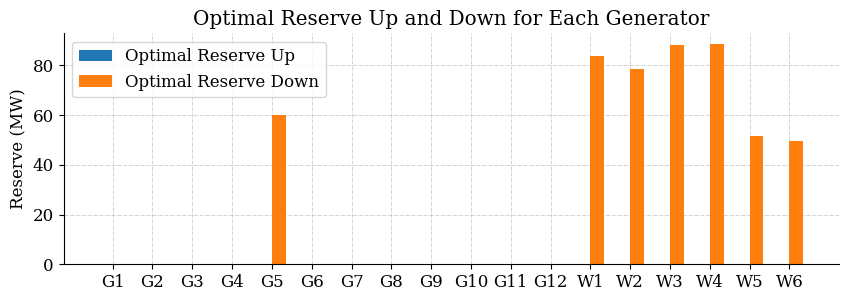

In [98]:
import matplotlib.pyplot as plt

# Define the generator labels
generator_labels = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 3))

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
bar_positions = range(len(generator_labels))

# Plot the optimal reserve up bars
ax.bar(bar_positions, optimal_reserve_up.values(), width=bar_width, label='Optimal Reserve Up')

# Plot the optimal reserve down bars
ax.bar([p + bar_width for p in bar_positions], optimal_reserve_down.values(), width=bar_width, label='Optimal Reserve Down')

# Set the x-axis tick labels
ax.set_xticks([p + bar_width / 2 for p in bar_positions])
ax.set_xticklabels(generator_labels)

# Set the y-axis label
ax.set_ylabel('Reserve (MW)')

# Set the title
ax.set_title('Optimal Reserve Up and Down for Each Generator')

# Add a legend
ax.legend()

# Show the plot
plt.show()


# Rewriting and accounting for covariance matrix

$\textbf{NOTE:}$

$\boldsymbol\Sigma$ is an $N$ x $N$ matrix and $\boldsymbol\alpha$ is a vector of length $N$

 (omitting the square root of Sigma for simplicity of notation):
\begin{align}
    \Phi^{-1}(1-\varepsilon)\cdot ||\boldsymbol\Sigma\cdot \boldsymbol\alpha||_2&\\ 
    &= \Phi^{-1}(1-\varepsilon)\cdot \sqrt{(\Sigma_{11}\alpha_1 + \Sigma_{12}\alpha_2 + ...+\Sigma_{1n}\alpha_n)^2 + (\Sigma_{21}\alpha_1 + \Sigma_{22}\alpha_2 + \Sigma_{2n}\alpha_n)^2 + ... + (\Sigma_{n1}\alpha_1 + \Sigma_{n2}\alpha_2 +\Sigma_{nn}\alpha_n)^2}\\
    &= \sqrt{\Big(\Phi^{-1}(1-\varepsilon)\cdot\big[\Sigma_{11}\alpha_1 + \Sigma_{12}\alpha_2 + ...+\Sigma_{1n}\alpha_n\big]\Big)^2 + ...}\\
\end{align}

Thus the auxiliary variables $x$ for the LHS of the chance constraints involving the euclidian norm $||.||_2$ can be defined as:

\begin{equation}
    x = 
    \begin{bmatrix}
        \Phi^{-1}(1-\varepsilon)\cdot\big[\Sigma_{11}\alpha_1 + \Sigma_{12}\alpha_2 + ...+\Sigma_{1n}\alpha_n\big]\\
        \Phi^{-1}(1-\varepsilon)\cdot\big[\Sigma_{21}\alpha_1 + \Sigma_{22}\alpha_2 + ...+\Sigma_{2n}\alpha_n\big]\\
        \vdots\\
        \Phi^{-1}(1-\varepsilon)\cdot\big[\Sigma_{n1}\alpha_1 + \Sigma_{n2}\alpha_2 + ...+\Sigma_{nn}\alpha_n\big]
    \end{bmatrix}
\end{equation}

Where the LHS becomes:
\begin{equation}
    \text{LHS} = x\cdot x^T = \sum_i{x_i^2}
\end{equation}

* for each constraint, save alpha as a vector for the loop

In [17]:
sigma = np.sqrt(cov) # we save Sigma^(1/2) as "sigma" in the code

In [29]:
def _solve_reserve_dimensioning_model_():
    
    # Create a Gurobi model for the optimization problem
    DA_model = gb.Model(name='Day-ahead economic dispatch and reserve dimensioning problem')
        
        
    # Set time limit
    DA_model.Params.TimeLimit = 500
    
    #==============================================================
    #FIRST-STAGE VARIABLES

    generator_dispatch = {} # electricity production of generators      
    generator_reserve_up = {} # upward reserves of generators        
    generator_reserve_down = {} # downward reserves of generators   

    for g in CONTROLLABLE_GENERATORS:
        generator_dispatch[g] = DA_model.addVar(lb=0,ub=generation_capacity[g],name='Dispatch of generator {0}'.format(g))
        generator_reserve_up[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[g],name='Upward reserve of generator {0}'.format(g))
        generator_reserve_down[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[g],name='Downward reserve of generator {0}'.format(g))

    for w in WIND_GENERATORS:
        generator_dispatch[w] = DA_model.addVar(lb=0,ub=generation_capacity[w],name='Dispatch of wind farm {0}'.format(w - 12))
        generator_reserve_up[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[w],name='Upward reserve of wind farm {0}'.format(w - 12))
        generator_reserve_down[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[w],name='Downward reserve of wind farm {0}'.format(w - 12))

    #==============================================================
    #SECOND-STAGE VARIABLES
    generator_adjustment_up_intersect = {} #LDR parameter (0)
    generator_adjustment_down_intersect = {} #LDR parameter (0)
    generator_adjustment_up = [] #LDR parameters (1) - (6)
    generator_adjustment_down = [] #LDR parameters (0) - (6)
    
    for g in GENERATORS:
        generator_adjustment_up_intersect[g] = DA_model.addVar(lb=-gb.GRB.INFINITY,name='upward adjustment LDR parameter of generator {0} '.format(g)) # electricity production adjustment of generators in real time (\Delta x^G_i)
        generator_adjustment_down_intersect[g] = DA_model.addVar(lb=-gb.GRB.INFINITY,name='downward adjustment LDR parameter of generator {0} '.format(g)) # electricity production adjustment of generators in real time (\Delta x^G_i)
    
    for w in range(NUM_WF): # 1 LDR parameter for each uncertain parameter for each generator adjustment
        generator_adjustment_up.append(
                                      {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('upward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS}
                                      )

        generator_adjustment_down.append(
                                        {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('downward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS}
                                        ) 

    #==============================================================
    #AUXILIARY VARIABLES for SOC constraints (non-negative)
    y = [{g:DA_model.addVar(lb=0) for g in GENERATORS} for n in range(6)] #RHS auxiliary variables - we have 6 chance constraints which require auxiliary variables

    #Constructing the LHS vectors associated with each chance constraint
    x_1 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_2 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_3 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_4 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_5 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_6 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in CONTROLLABLE_GENERATORS} for w in range(NUM_WF)]
    x_7 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in WIND_GENERATORS} for w in range(NUM_WF)]
     
    #==============================================================
    # SET OBJECTIVE
    DA_model.update()
    
    total_cost = gb.quicksum(dispatch_cost[g] * generator_dispatch[g] 
                             + reserve_cost_up[g] * generator_reserve_up[g] 
                             + reserve_cost_down[g] * generator_reserve_down[g] 
                             + adjustment_cost_up[g] * generator_adjustment_up_intersect[g] 
                             - adjustment_cost_down[g] * generator_adjustment_down_intersect[g] 
                             + gb.quicksum(wind_availability_expected[w] * (adjustment_cost_up[g] * generator_adjustment_up[w][g] 
                                                                            - adjustment_cost_down[g] * generator_adjustment_down[w][g]) for w in range(NUM_WF))
                             for g in GENERATORS) # expected electricity production cost
    
    DA_model.setObjective(total_cost, gb.GRB.MINIMIZE) #minimize cost

    #===============================================================
    # ADD CONSTRAINTS (regular day-ahead and robust)

    # DA balance equation (Eq. 34 in report)
    DA_model.addConstr(gb.quicksum(generator_dispatch[g] for g in GENERATORS) == LOAD, name='Day-ahead balance equation')
 

    # DA_dispatch_min_constraint (Eq. 40 and 41 in report)
    for g in GENERATORS:
        DA_model.addLConstr(generator_dispatch[g] - generator_reserve_down[g], gb.GRB.GREATER_EQUAL, 0, name='day-ahead dispatch and reserved capacity lower bound')
    
    # DA_dispatch_max_constraint for synchronous generators (Eq. 39 in report)
    for g in CONTROLLABLE_GENERATORS:
        DA_model.addLConstr(generator_dispatch[g] + generator_reserve_up[g], gb.GRB.LESS_EQUAL, generation_capacity[g], name='day-ahead dispatch and reserved capacity upper bound')
    

    #reformulation of ROBUST RT_balance_constriant (Eq. 43) (the equation is split into separate parts all equal to 0)      
    DA_model.addLConstr(gb.quicksum(generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g] for g in GENERATORS), gb.GRB.EQUAL, 0,
                        name='real-time balance equation (intercept of LDR)')

    for w in range(NUM_WF):
            DA_model.addLConstr(gb.quicksum(generator_adjustment_up[w][g] - generator_adjustment_down[w][g] for g in GENERATORS), gb.GRB.EQUAL, 0,
                                name='real-time balance equation (slope of LDR associated with wind power of WF%d)' % w) 

    #===============================================================
    # ADD CONSTRAINTS (chance-constrained)


    # reformulation of CHANCE-CONSTRAINED DA_dispatch_max_constraint for wind generators (Eq. 42)
    k = 0 #to keep track of wind farm index through the loop
    for g in WIND_GENERATORS:
        DA_model.addLConstr(norm.ppf(1-epsilon) * sigma[k,k] * (-1 * generation_capacity[g]), 
                            gb.GRB.LESS_EQUAL,
                            - generator_dispatch[g] - generator_reserve_up[g] - wind_availability_expected[k] * (-1* generation_capacity[g]), 
                            name='day-ahead dispatch and reserved capacity upper bound')
        k+=1


    # reformulation of chance-constrained adjustment_up_min_constraint (Eq. 44a & 46a)
    

    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_1[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[0][g]**2,
                            name='chance-constrained reformulation of adjustment_up_min_constraint 1/2')

        alpha = [(-1 * generator_adjustment_up[w][g]) for w in range(NUM_WF)]

        #define auxiliary variables for RHS
        DA_model.addLConstr(y[0][g], gb.GRB.EQUAL,
                            generator_adjustment_up_intersect[g]
                            - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                            name='chance-constrained reformulation of adjustment_up_min_constraint 2/2')
        
    #define auxiliary variables for LHS
    for w in range(NUM_WF): 
        for g in GENERATORS:
            DA_model.addLConstr(x_1[w][g], 
                                gb.GRB.EQUAL,
                                norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                name='chance-constrained reformulation of adjustment_up_min_constraint 2/2')
            

    # reformulation of chance-constrained adjustment_down_min_constraint (Eq. 45a and 47a)
    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_2[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[1][g]**2,
                            name='chance-constrained reformulation of adjustment_down_min_constraint 1/2')

        alpha = [(-1 * generator_adjustment_down[w][g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[1][g], gb.GRB.EQUAL,
                            generator_adjustment_down_intersect[g]
                            - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                            name='chance-constrained reformulation of adjustment_down_min_constraint 2/2')

    for w in range(NUM_WF):
        for g in GENERATORS:
            DA_model.addLConstr(x_2[w][g], gb.GRB.EQUAL,
                                norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                name='chance-constrained reformulation of adjustment_down_min_constraint 2/2')


    # reformulation of chance-constrained adjustment_up_max_constraint (Eq. 44b and 46b)
    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_3[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[2][g]**2,
                            name='chance-constrained reformulation of adjustment_up_max_constraint 1/2')

        alpha = [(generator_adjustment_up[w][g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[2][g], gb.GRB.EQUAL,
                                    - generator_adjustment_up_intersect[g] + generator_reserve_up[g]
                                    - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                                    name='chance-constrained reformulation of adjustment_up_max_constraint 2/2')

    for w in range(NUM_WF):
        for g in GENERATORS:
            DA_model.addLConstr(x_3[w][g], gb.GRB.EQUAL,
                                    norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                    name='chance-constrained reformulation of adjustment_up_max_constraint 2/2')


    # reformulation of chance-constrained adjustment_down_max_constraint (Eq. 45b and 47b)
    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_4[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[3][g]**2,
                            name='chance-constrained reformulation of adjustment_down_max_constraint 1/2')

        alpha = [(generator_adjustment_down[w][g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[3][g], gb.GRB.EQUAL,
                                - generator_adjustment_down_intersect[g] + generator_reserve_down[g] 
                                - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                                name='chance-constrained reformulation of adjustment_down_max_constraint 2/2')

    for w in range(NUM_WF):
        for g in GENERATORS:
            DA_model.addLConstr(x_4[w][g], gb.GRB.EQUAL,
                                    norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                    name='chance-constrained reformulation of adjustment_down_max_constraint 2/2')

    # reformulation of chance-constrained RT_min_production_constraint (Eq. 48a & 49a)
    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_5[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[4][g]**2,
                            name='chance-constrained reformulation of RT_min_production_constraint 1/2')

        alpha = [(-1* generator_adjustment_up[w][g] + generator_adjustment_down[w][g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[4][g], gb.GRB.EQUAL,
                                generator_dispatch[g] + generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g]
                                - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                                name='chance-constrained reformulation of RT_min_production_constraint 2/2')
        
    for w in range(NUM_WF):
        for g in GENERATORS:
            DA_model.addLConstr(x_5[w][g], gb.GRB.EQUAL,
                                    norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                    name='chance-constrained reformulation of adjustment_up_min_constraint 2/2')

    # reformulation of chance-constrained RT_max_production_constraint (Eq. 48b and 49b)   
    
    #48b
    for g in CONTROLLABLE_GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_6[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[5][g]**2,
                            name='chance-constrained reformulation of RT_min_production_constraint 1/2') 

        alpha = [(generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[5][g], gb.GRB.EQUAL,
                                - generation_capacity[g] - generator_adjustment_up_intersect[g]
                                + generator_adjustment_down_intersect[g] + generator_dispatch[g]
                                - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                                name='chance-constrained reformulation of RT_min_production_constraint 2/2') 

    for w in range(NUM_WF):
        for g in CONTROLLABLE_GENERATORS:
            DA_model.addLConstr(x_6[w][g], gb.GRB.EQUAL,
                                    norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                    name='chance-constrained reformulation of adjustment_up_max_constraint 2/2')


    #49b
    k=0
    for g in WIND_GENERATORS:

        DA_model.addQConstr(gb.quicksum(x_7[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[5][g]**2,
                            name='chance-constrained reformulation of RT_min_production_constraint 1/2') 

        alpha = [(generator_adjustment_up[w][g] - generator_adjustment_down[w][g] - generation_capacity[g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[5][g], gb.GRB.EQUAL,
                                - generator_dispatch[g] - generator_adjustment_up_intersect[g] + generator_adjustment_down_intersect[g] 
                                - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                                name='chance-constrained reformulation of RT_min_production_constraint 2/2') 
        
    for w in range(NUM_WF):   
        for g in WIND_GENERATORS:                                                                                                                 
            DA_model.addLConstr(x_7[w][g], gb.GRB.EQUAL, 
                                norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)), 
                                name='chance-constrained reformulation of RT_min_production_constraint 1/2') 
        k+=1

    #====================================================================
    # OPTIMIZE AND SAVE RESULTS

    DA_model.optimize()
    
    optimal_DA_objval = DA_model.ObjVal
    optimal_DA_cost = sum(dispatch_cost[g]*generator_dispatch[g].x for g in GENERATORS)
    optimal_reserve_cost = sum(reserve_cost_up[g]*generator_reserve_up[g].x + reserve_cost_down[g]*generator_reserve_down[g].x for g in GENERATORS)
    optimal_DA_dispatch = {g:generator_dispatch[g].x for g in GENERATORS}
    optimal_reserve_up = {g:generator_reserve_up[g].x for g in GENERATORS}
    optimal_reserve_down = {g:generator_reserve_down[g].x for g in GENERATORS}
    
    return optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down


optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down = _solve_reserve_dimensioning_model_()

Set parameter TimeLimit to value 500
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 800 rows, 1062 columns and 7362 nonzeros
Model fingerprint: 0x299343c5
Model has 108 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-02, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-01, 3e+01]
  Bounds range     [3e+01, 6e+02]
  RHS range        [6e+01, 2e+03]
Presolve removed 6 rows and 198 columns
Presolve time: 0.00s

Barrier solved model in 0 iterations and 0.00 seconds (0.00 work units)
Model is infeasible or unbounded


AttributeError: Unable to retrieve attribute 'ObjVal'

# Debugging (changing one constraint reformulation at a time)

In [37]:
pd.DataFrame(sigma)

,0,1,2,3,4,5
0,0.10556,0.08718,0.08510,0.06967,0.01386,0.04023
1,0.08718,0.12813,0.08811,0.08107,0.04517,0.05034
2,0.08510,0.08811,0.13570,0.10246,0.01887,0.04089
3,0.06967,0.08107,0.10246,0.12209,0.04042,0.04848
4,0.01386,0.04517,0.01887,0.04042,0.07532,0.01431
5,0.04023,0.05034,0.04089,0.04848,0.01431,0.11799


In [46]:
def _solve_reserve_dimensioning_model_():
    
    # Create a Gurobi model for the optimization problem
    DA_model = gb.Model(name='Day-ahead economic dispatch and reserve dimensioning problem')
        
        
    # Set time limit
    DA_model.Params.TimeLimit = 500
    
    #==============================================================
    #FIRST-STAGE VARIABLES

    generator_dispatch = {} # electricity production of generators      
    generator_reserve_up = {} # upward reserves of generators        
    generator_reserve_down = {} # downward reserves of generators   

    for g in CONTROLLABLE_GENERATORS:
        generator_dispatch[g] = DA_model.addVar(lb=0,ub=generation_capacity[g],name='Dispatch of generator {0}'.format(g))
        generator_reserve_up[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[g],name='Upward reserve of generator {0}'.format(g))
        generator_reserve_down[g] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[g],name='Downward reserve of generator {0}'.format(g))

    for w in WIND_GENERATORS:
        generator_dispatch[w] = DA_model.addVar(lb=0,ub=generation_capacity[w],name='Dispatch of wind farm {0}'.format(w - 12))
        generator_reserve_up[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_up[w],name='Upward reserve of wind farm {0}'.format(w - 12))
        generator_reserve_down[w] = DA_model.addVar(lb=0,ub=adjustment_capacity_down[w],name='Downward reserve of wind farm {0}'.format(w - 12))

    #==============================================================
    #SECOND-STAGE VARIABLES
    generator_adjustment_up_intersect = {} #LDR parameter (0)
    generator_adjustment_down_intersect = {} #LDR parameter (0)
    generator_adjustment_up = [] #LDR parameters (1) - (6)
    generator_adjustment_down = [] #LDR parameters (0) - (6)
    
    for g in GENERATORS:
        generator_adjustment_up_intersect[g] = DA_model.addVar(lb=-gb.GRB.INFINITY,name='upward adjustment LDR parameter of generator {0} '.format(g)) # electricity production adjustment of generators in real time (\Delta x^G_i)
        generator_adjustment_down_intersect[g] = DA_model.addVar(lb=-gb.GRB.INFINITY,name='downward adjustment LDR parameter of generator {0} '.format(g)) # electricity production adjustment of generators in real time (\Delta x^G_i)
    
    for w in range(NUM_WF): # 1 LDR parameter for each uncertain parameter for each generator adjustment
        generator_adjustment_up.append(
                                      {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('upward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS}
                                      )

        generator_adjustment_down.append(
                                        {g:DA_model.addVar(lb=-gb.GRB.INFINITY,name=('downward adjustment LDR parameter (%d) of generator %d' % (w, g))) for g in GENERATORS}
                                        ) 

    #==============================================================
    #AUXILIARY VARIABLES for SOC constraints (non-negative)
    y = [{g:DA_model.addVar(lb=0) for g in GENERATORS} for n in range(6)] #RHS auxiliary variables - we have 6 chance constraints which require auxiliary variables

    #Constructing the LHS vectors associated with each chance constraint
    x_1 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_2 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_3 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_4 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_5 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in GENERATORS} for w in range(NUM_WF)]
    x_6 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in CONTROLLABLE_GENERATORS} for w in range(NUM_WF)]
    x_7 = [{g:DA_model.addVar(lb=-gb.GRB.INFINITY) for g in WIND_GENERATORS} for w in range(NUM_WF)]
     
    #==============================================================
    # SET OBJECTIVE
    DA_model.update()
    
    total_cost = gb.quicksum(dispatch_cost[g] * generator_dispatch[g] 
                             + reserve_cost_up[g] * generator_reserve_up[g] 
                             + reserve_cost_down[g] * generator_reserve_down[g] 
                             + adjustment_cost_up[g] * generator_adjustment_up_intersect[g] 
                             - adjustment_cost_down[g] * generator_adjustment_down_intersect[g] 
                             + gb.quicksum(wind_availability_expected[w] * (adjustment_cost_up[g] * generator_adjustment_up[w][g] 
                                                                            - adjustment_cost_down[g] * generator_adjustment_down[w][g]) for w in range(NUM_WF))
                             for g in GENERATORS) # expected electricity production cost
    
    DA_model.setObjective(total_cost, gb.GRB.MINIMIZE) #minimize cost

    #===============================================================
    # ADD CONSTRAINTS (regular day-ahead and robust)

    # DA balance equation (Eq. 34 in report)
    DA_model.addConstr(gb.quicksum(generator_dispatch[g] for g in GENERATORS) == LOAD, name='Day-ahead balance equation')
 

    # DA_dispatch_min_constraint (Eq. 40 and 41 in report)
    for g in GENERATORS:
        DA_model.addLConstr(generator_dispatch[g] - generator_reserve_down[g], gb.GRB.GREATER_EQUAL, 0, name='day-ahead dispatch and reserved capacity lower bound')
    
    # DA_dispatch_max_constraint for synchronous generators (Eq. 39 in report)
    for g in CONTROLLABLE_GENERATORS:
        DA_model.addLConstr(generator_dispatch[g] + generator_reserve_up[g], gb.GRB.LESS_EQUAL, generation_capacity[g], name='day-ahead dispatch and reserved capacity upper bound')
    

    #reformulation of ROBUST RT_balance_constriant (Eq. 43) (the equation is split into separate parts all equal to 0)      
    DA_model.addLConstr(gb.quicksum(generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g] for g in GENERATORS), gb.GRB.EQUAL, 0,
                        name='real-time balance equation (intercept of LDR)')

    for w in range(NUM_WF):
            DA_model.addLConstr(gb.quicksum(generator_adjustment_up[w][g] - generator_adjustment_down[w][g] for g in GENERATORS), gb.GRB.EQUAL, 0,
                                name='real-time balance equation (slope of LDR associated with wind power of WF%d)' % w) 
            
    #===============================================================
    # CHANCE CONSTRAINTS
    # NO ISSUES:

    k = 0 #to keep track of wind farm index through the loop
    for g in WIND_GENERATORS:
        DA_model.addLConstr(norm.ppf(1-epsilon) * sigma[k,k] * (-1 * generation_capacity[g]), 
                            gb.GRB.LESS_EQUAL,
                            - generator_dispatch[g] - generator_reserve_up[g] - wind_availability_expected[k] * (-1* generation_capacity[g]), 
                            name='day-ahead dispatch and reserved capacity upper bound')
        k+=1

    # reformulation of chance-constrained adjustment_up_min_constraint (Eq. 44a & 46a)
    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_1[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[0][g]**2,
                            name='chance-constrained reformulation of adjustment_up_min_constraint 1/2')

        alpha = [(-1 * generator_adjustment_up[w][g]) for w in range(NUM_WF)]

        #define auxiliary variables for RHS
        DA_model.addLConstr(y[0][g], gb.GRB.EQUAL,
                            generator_adjustment_up_intersect[g]
                            - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                            name='chance-constrained reformulation of adjustment_up_min_constraint 2/2')
        
    #define auxiliary variables for LHS
    for w in range(NUM_WF): 
        for g in GENERATORS:
            DA_model.addLConstr(x_1[w][g], 
                                gb.GRB.EQUAL,
                                norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                name='chance-constrained reformulation of adjustment_up_min_constraint 2/2')


    #==================================
    #PROBLEMATIC (where it starts to become infeasible):

    
    # reformulation of chance-constrained adjustment_down_min_constraint (Eq. 45a and 47a)
    for g in GENERATORS:
        DA_model.addQConstr(gb.quicksum(x_2[w][g]**2 for w in range(NUM_WF)), gb.GRB.LESS_EQUAL, y[1][g]**2,
                            name='chance-constrained reformulation of adjustment_down_min_constraint 1/2')

        alpha = [(-1 * generator_adjustment_down[w][g]) for w in range(NUM_WF)]

        DA_model.addLConstr(y[1][g], gb.GRB.EQUAL,
                            generator_adjustment_down_intersect[g]
                            - gb.quicksum(wind_availability_expected[w] * alpha[w] for w in range(NUM_WF)),
                            name='chance-constrained reformulation of adjustment_down_min_constraint 2/2')

    for w in range(NUM_WF):
        for g in GENERATORS:
            DA_model.addLConstr(x_2[w][g], gb.GRB.EQUAL,
                                norm.ppf(1-epsilon) * gb.quicksum(sigma[w,k] * alpha[k] for k in range(NUM_WF)),
                                name='chance-constrained reformulation of adjustment_down_min_constraint 2/2')
            
            

    #==================================
    #UNTESTED:


    # reformulation of chance-constrained adjustment_up_max_constraint (Eq. 44b and 46b)
    adjustement_up_max_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_3[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[2][g]**2,name='chance-constrained reformulation of adjustment_up_max_constraint 1/2') for g in GENERATORS} 

    adjustement_up_max_constraint_2 = {g:DA_model.addLConstr(y[2][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_reserve_up[g]-generator_adjustment_up_intersect[g]
                                                       - gb.quicksum(wind_availability_expected[w] * generator_adjustment_up[w][g] for w in range(NUM_WF)),
                                                       name='chance-constrained reformulation of adjustment_up_max_constraint 2/2') for g in GENERATORS} 

    adjustement_up_max_constraint = []
    for w in range(NUM_WF):
        adjustement_up_max_constraint.append({g:DA_model.addLConstr(x_3[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_up[w][g],
                                                       name='chance-constrained reformulation of adjustment_up_max_constraint 2/2') for g in GENERATORS} 
        )

    # reformulation of chance-constrained adjustment_down_max_constraint (Eq. 45b and 47b)
    adjustement_down_max_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_4[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[3][g]**2,name='chance-constrained reformulation of adjustment_down_max_constraint 1/2') for g in GENERATORS} 

    adjustement_down_max_constraint_2 = {g:DA_model.addLConstr(y[3][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_reserve_down[g] - generator_adjustment_down_intersect[g]
                                                       - gb.quicksum(wind_availability_expected[w] * generator_adjustment_down[w][g] for w in range(NUM_WF)),
                                                       name='chance-constrained reformulation of adjustment_down_max_constraint 2/2') for g in GENERATORS} 

    adjustement_down_max_constraint = []
    for w in range(NUM_WF):
        adjustement_down_max_constraint.append({g:DA_model.addLConstr(x_4[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon) * wind_availability_standard_deviation[w] * generator_adjustment_down[w][g],
                                                       name='chance-constrained reformulation of adjustment_down_max_constraint 2/2') for g in GENERATORS} 
        )

    # reformulation of chance-constrained RT_min_production_constraint (Eq. 48a)
    RT_min_production_constraint_1 = {g:DA_model.addQConstr(gb.quicksum(x_5[w][g]**2 for w in range(NUM_WF)), 
                                                       gb.GRB.LESS_EQUAL,
                                                       y[4][g]**2,name='chance-constrained reformulation of RT_min_production_constraint 1/2') for g in GENERATORS} 

    RT_min_production_constraint_2 = {g:DA_model.addLConstr(y[4][g], 
                                                       gb.GRB.EQUAL,
                                                       generator_dispatch[g] + generator_adjustment_up_intersect[g] - generator_adjustment_down_intersect[g]
                                                       + gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(NUM_WF)),
                                                        name='chance-constrained reformulation of RT_min_production_constraint 2/2') for g in GENERATORS} 
    RT_min_production_constraint = []
    for w in range(NUM_WF):
        RT_min_production_constraint.append({g:DA_model.addLConstr(x_5[w][g], 
                                                       gb.GRB.EQUAL,
                                                       norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]-generator_adjustment_down[w][g]),
                                                       name='chance-constrained reformulation of adjustment_up_min_constraint 2/2') for g in GENERATORS}  
        )

    # reformulation of chance-constrained RT_max_production_constraint (Eq. 48b and 49b)
    RT_max_production_constraint_1 = {}
    RT_max_production_constraint_2 = {}
    RT_max_production_constraint_3 = {}
    
    
    for g in CONTROLLABLE_GENERATORS:
        RT_max_production_constraint_1[g] = DA_model.addQConstr(gb.quicksum(x_6[w][g]**2 for w in range(NUM_WF)), 
                                                           gb.GRB.LESS_EQUAL,
                                                           y[5][g]**2,name='chance-constrained reformulation of RT_min_production_constraint 1/2') 

        RT_max_production_constraint_2[g] = DA_model.addLConstr(y[5][g], 
                                                           gb.GRB.EQUAL,
                                                           generation_capacity[g]-generator_dispatch[g]
                                                           -generator_adjustment_up_intersect[g]+generator_adjustment_down_intersect[g]
                                                           -gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[w][g] - generator_adjustment_down[w][g]) for w in range(NUM_WF)),
                                                           name='chance-constrained reformulation of RT_min_production_constraint 2/2') 

    RT_max_production_constraint = []
    for w in range(NUM_WF):
        RT_max_production_constraint.append({g:DA_model.addLConstr(x_6[w][g], 
                                                        gb.GRB.EQUAL,
                                                        norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]-generator_adjustment_down[w][g]),
                                                        name='chance-constrained reformulation of adjustment_up_max_constraint 2/2') for g in CONTROLLABLE_GENERATORS}  
        )


    k=0
    for g in WIND_GENERATORS:

        RT_max_production_constraint_1[g] = DA_model.addQConstr(gb.quicksum(x_7[w][g]**2 for w in range(NUM_WF)), 
                                                    gb.GRB.LESS_EQUAL,
                                                    y[5][g]**2,name='chance-constrained reformulation of RT_min_production_constraint 1/2') 


        RT_max_production_constraint_2[g] = DA_model.addLConstr(y[5][g], 
                                                    gb.GRB.EQUAL,
                                                    -generator_dispatch[g] - generator_adjustment_up_intersect[g] + generator_adjustment_down_intersect[g]
                                                    -gb.quicksum(wind_availability_expected[w] * (generator_adjustment_up[k][g] - generator_adjustment_down[k][g]) for w in range(NUM_WF))
                                                    -wind_availability_expected[k] * generation_capacity[g],
                                                    name='chance-constrained reformulation of RT_min_production_constraint 2/2') 
        for w in range(NUM_WF):
            if w == k:
                rhs = norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]
                                                                                -generator_adjustment_down[w][g]
                                                                                -generation_capacity[g])
            else:
                rhs = norm.ppf(1-epsilon)*wind_availability_standard_deviation[w]*(generator_adjustment_up[w][g]
                                                                                -generator_adjustment_down[w][g])
                                                                                                                    
            RT_max_production_constraint_3[g] = DA_model.addLConstr(x_7[w][g], 
                                                    gb.GRB.EQUAL,
                                                        rhs,
                                                        name='chance-constrained reformulation of RT_min_production_constraint 1/2') 
        k+=1

    # optimize ED problem (primal)
    DA_model.optimize()
    
    optimal_DA_objval = DA_model.ObjVal
    optimal_DA_cost = sum(dispatch_cost[g]*generator_dispatch[g].x for g in GENERATORS)
    optimal_reserve_cost = sum(reserve_cost_up[g]*generator_reserve_up[g].x + reserve_cost_down[g]*generator_reserve_down[g].x for g in GENERATORS)
    optimal_DA_dispatch = {g:generator_dispatch[g].x for g in GENERATORS}
    optimal_reserve_up = {g:generator_reserve_up[g].x for g in GENERATORS}
    optimal_reserve_down = {g:generator_reserve_down[g].x for g in GENERATORS}
    
    return optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down


optimal_DA_objval, optimal_DA_cost, optimal_reserve_cost, optimal_DA_dispatch, optimal_reserve_up, optimal_reserve_down = _solve_reserve_dimensioning_model_()

Set parameter TimeLimit to value 500
-1.0 downward adjustment LDR parameter (0) of generator 17
-1.0 downward adjustment LDR parameter (1) of generator 17
-1.0 downward adjustment LDR parameter (2) of generator 17
-1.0 downward adjustment LDR parameter (3) of generator 17
-1.0 downward adjustment LDR parameter (4) of generator 17
-1.0 downward adjustment LDR parameter (5) of generator 17
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 800 rows, 1062 columns and 3522 nonzeros
Model fingerprint: 0x4fd71638
Model has 108 quadratic constraints
Coefficient statistics:
  Matrix range     [7e-03, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-01, 3e+01]
  Bounds range     [3e+01, 6e+02]
  RHS range        [2e+00, 2e+03]
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Pr

AttributeError: Unable to retrieve attribute 'ObjVal'